<a href="https://colab.research.google.com/github/adamehayman/AMII/blob/main/2_Decision_Tree_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Decision Tree Classifier Introduction**  
  
Although decision trees may not be the fanciest algorithms out there, they are still a useful tool to visualize the decision-making process. They provide insights into which features are dominating the decisions and results.  
In this example, we will try to predict 5 different classes, with the emphasis on those that are closer to the actual RUL, as that aligns with our business objective.  
We will import the dataframes from the EDA process in the previous notebook.

In [ ]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

## **Import Data**

In [ ]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 163, done.
remote: Total 163 (delta 0), reused 0 (delta 0), pack-reused 163
Receiving objects: 100% (163/163), 55.80 MiB | 28.09 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/cloned-repo
1_NASA_FD001_EDA.ipynb			   5_XGBoost.ipynb
2_10_Class_Decision_Tree_Classifier.ipynb  FIgures.pptx
3_5_Class_Decision_Tree_Classifier.ipynb   NASA_TurboFan_Data
4_RandomForest.ipynb			   README.md


In [ ]:
train1_class = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/train1_new.csv')
test1_class = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/test1.csv')

In [ ]:
sensor2keep = ['T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32']
col2keep = ['Unit', 'T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32', 'RUL']

In [ ]:
test1_class = test1_class[col2keep]

## **Data Visualization**  
  
Plots of every 10th unit for the two most strongly correlated sensors with RUL, Ps30 and T50

In [ ]:
# Strongest Negative Correlation from previous EDA notebook

str_corr = ['Ps30', 'T50']

In [ ]:
# Function to plot every 10th unit

def plot_sensor(sensor_name):
    plt.figure(figsize=(20,5))
    for i in train1_class['Unit'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train1_class[train1_class['Unit']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

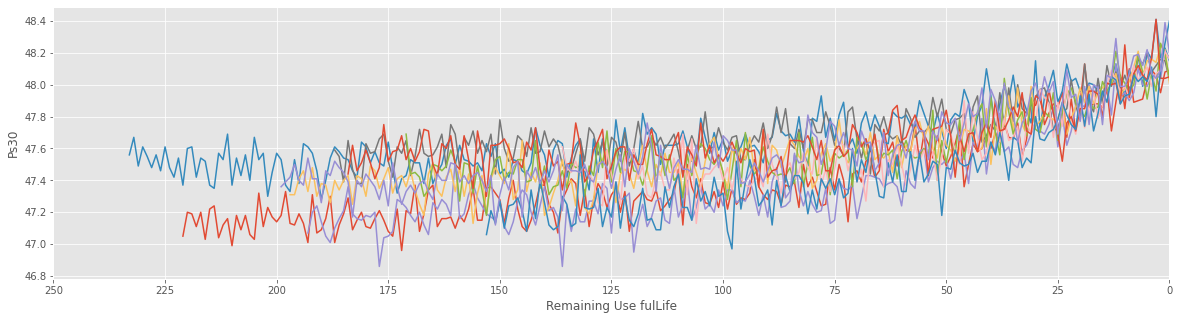

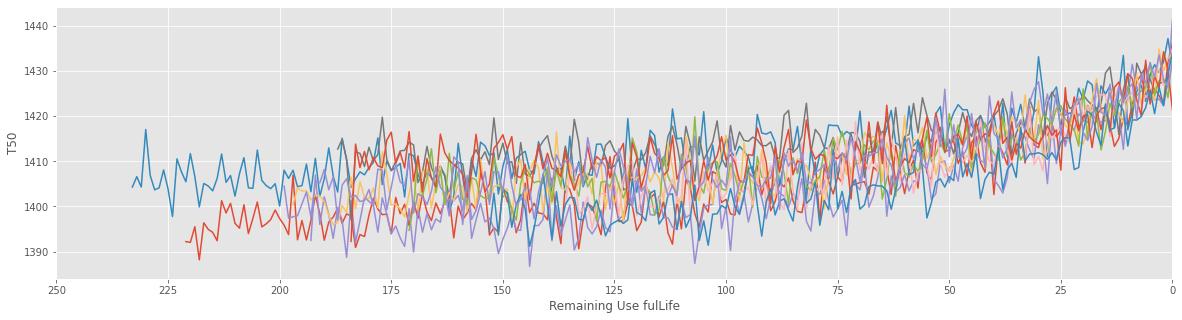

In [ ]:
for sensor_name in str_corr:
    plot_sensor(sensor_name)

## **Label Data Discretization - Creating RUL Classes for train1 and test1**  

As we saw in the previous notebook, 2_10_Class_Decision_Tree_Classifier, the model had a difficult time distinguishing between classes 5 to 10. We will try focusing on when the degradation begins.  
  
class 1 = RUL 0-20    
class 2 = RUL 20-40  
class 3 = RUL 40-60    
class 4 = RUL 60-80    
class 5 = RUL > 80

## **Original Split from previous notebook**
# 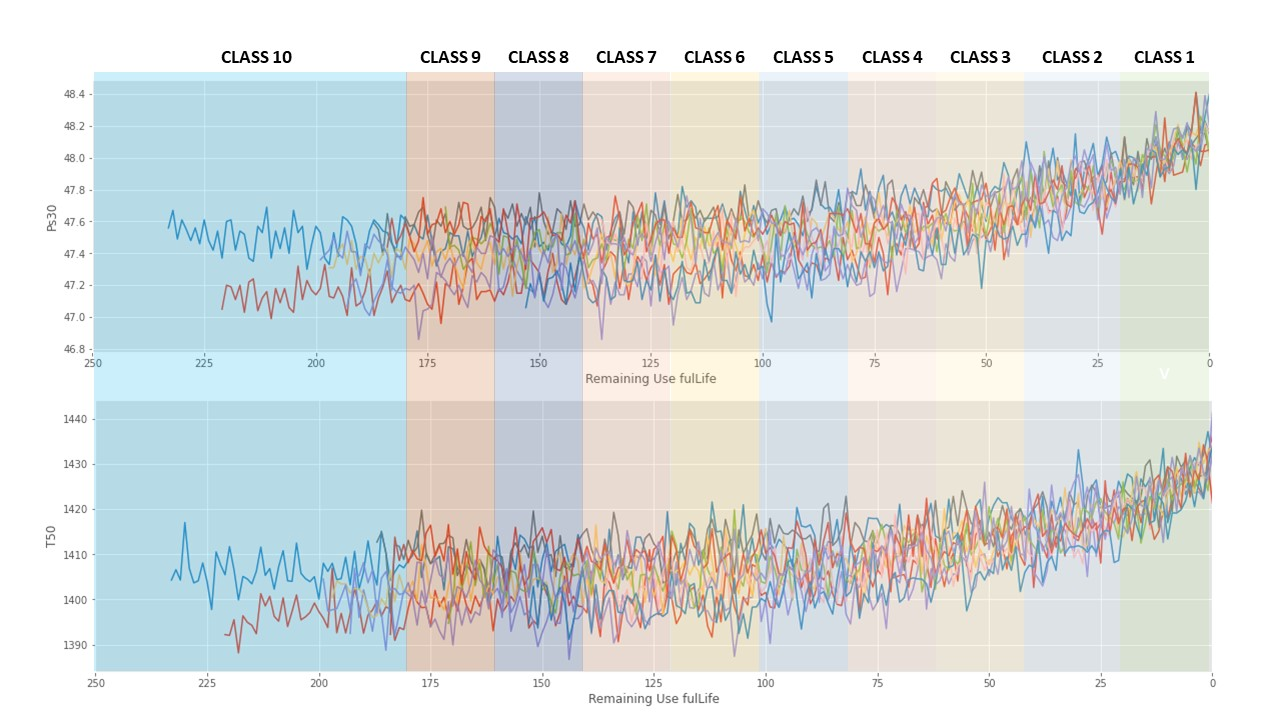

## **New Split based on degradation**
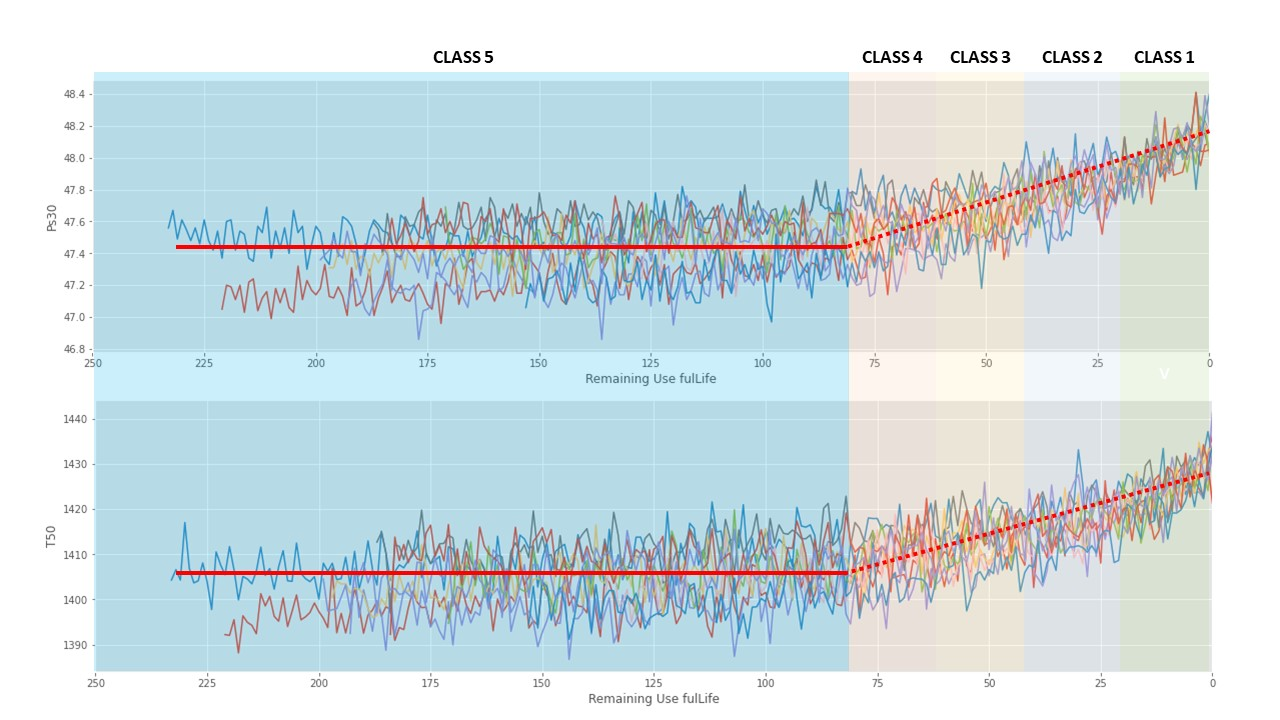

The above graph illustrates why our previous model had difficulties distinguishing between classes 5-10. We will now focus more on the classes where the degradation began to accelerate.

### **train1_class**

In [ ]:
for ii in range(len(train1_class)):

    curr_RUL = train1_class.loc[ii, 'RUL']

    if curr_RUL >= 0 and curr_RUL < 20:
        train1_class.loc[ii, 'RUL class'] = int(1)
    elif curr_RUL >= 20 and curr_RUL < 40:
        train1_class.loc[ii, 'RUL class'] = int(2)
    elif curr_RUL >= 40 and curr_RUL < 60:
        train1_class.loc[ii, 'RUL class'] = int(3)
    elif curr_RUL >= 60 and curr_RUL < 80:
        train1_class.loc[ii, 'RUL class'] = int(4)
    else:
        train1_class.loc[ii, 'RUL class'] = int(5)

In [ ]:
train1_class['RULclass'] = train1_class['RUL class'].astype(int)
train1_class.drop('RUL class', axis=1, inplace=True)

### **test1_class**

In [ ]:
for ii in range(len(test1_class)):

    curr_RUL = test1_class.loc[ii, 'RUL']

    if curr_RUL >= 0 and curr_RUL < 20:
        test1_class.loc[ii, 'RUL class'] = int(1)
    elif curr_RUL >= 20 and curr_RUL < 40:
        test1_class.loc[ii, 'RUL class'] = int(2)
    elif curr_RUL >= 40 and curr_RUL < 60:
        test1_class.loc[ii, 'RUL class'] = int(3)
    elif curr_RUL >= 60 and curr_RUL < 80:
        test1_class.loc[ii, 'RUL class'] = int(4)
    else:
        test1_class.loc[ii, 'RUL class'] = int(5)

In [ ]:
test1_class['RULclass'] = test1_class['RUL class'].astype(int)
test1_class.drop('RUL class', axis=1, inplace=True)

### **RULclass Distribution**  
Examine the RULclass distribution so we can create bins for StratifiedShuffleSplit

In [ ]:
fig = px.histogram(train1_class, x='RULclass')
fig.show()

In [ ]:
train1_class['RULclass'].value_counts()

5    12631
4     2000
3     2000
2     2000
1     2000
Name: RULclass, dtype: int64

From the above class distribution, we can see we have an imbalanced dataset, as expected.
Since we made a RULclass column, we will also have to drop the RUL column or the algorithm will simply use that to predict the RULclass. We will also drop the Unit column as that could lead to invalid predictions. We will also drop the columns that we discovered, from the last notebook, will likely provide little insight.

In [ ]:
train1_class.drop(['RUL', 'Unit', 'P15', 'NRc'], axis=1, inplace=True)

In [ ]:
train1_class.reset_index(drop=True, inplace=True)

In [ ]:
test1_class.drop(['RUL', 'Unit', 'P15', 'NRc'], axis=1, inplace=True)

In [ ]:
test1_class.reset_index(drop=True, inplace=True)

In [ ]:
train1_class.head()

,T24,T30,T50,P30,Ps30,phi,NRf,BPR,htBleed,w31,w32,RULclass
0,641.82,1589.70,1400.60,554.36,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,5
1,642.15,1591.82,1403.14,553.75,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,5
2,642.35,1587.99,1404.20,554.26,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,5
3,642.35,1582.79,1401.87,554.45,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,5
4,642.37,1582.85,1406.22,554.00,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,5


## **Imbalanced Dataset**  
  
We will implement a few different techniques to tackle our imbalanced dataset. We will be using the Imbalanced-learn library (https://imbalanced-learn.org/)  

In [ ]:
pip install -U imbalanced-learn

     |████████████████████████████████| 215kB 4.2MB/s 
     |████████████████████████████████| 22.2MB 161kB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


### **ADASYN: Adaptive synthetic sampling approach for imbalanced learning**  
  
How ADASYN is implemented:  
  
1.  calculate the ratio of minority to majority examples
2.  calculate the total number of synthetic data to generate
3.  find the k-Nearest neighbors of each minority example and calculate the rᵢ value. After this step, each minority example will be associated with a different neighborhood. The rᵢ value indicates the dominance of the majority class in each specific neighborhood. Higher rᵢ neighbourhoods contain more majority class examples and are more difficult to learn.
4.  Normalize the rᵢ values so that the sum of all rᵢ values equals to 1.
5.  Calculate the amount of synthetic examples to generate per neighbourhood. Because rᵢ is higher for neighbourhoods dominated by majority class examples, more synthetic minority class examples will be generated for those neighbourhoods. Hence, this gives the ADASYN algorithm its adaptive nature; more data is generated for “harder-to-learn” neighbourhoods.
6.  Generate Gᵢ data for each neighbourhood. First, take the minority example for the neighbourhood, xᵢ. Then, randomly select another minority example within that neighbourhood, xzᵢ.

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
X_train_adasyn = train1_class.drop(['RULclass'], axis=1)
y_train_adasyn = train1_class['RULclass'].copy()

In [ ]:
ada = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train_adasyn, y_train_adasyn)

In [ ]:
fig = px.histogram(y_train_adasyn, x='RULclass')
fig.show()

In [ ]:
y_train_adasyn.value_counts()

1    12834
3    12720
5    12631
4    12547
2    12414
Name: RULclass, dtype: int64

### **Recombine data into DataFrame before shuffle split**

In [ ]:
ADASYN_df = pd.concat([X_train_adasyn, y_train_adasyn], axis=1)

## **Stratified-Shuffle Split**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(ADASYN_df, ADASYN_df['RULclass']):
  ADASYN_train = ADASYN_df.loc[train_index]
  ADASYN_val = ADASYN_df.loc[test_index]

In [ ]:
StratSplit = ADASYN_val['RULclass'].value_counts() / len(ADASYN_val)
Dist = ADASYN_df['RULclass'].value_counts() / len(ADASYN_df)

Create a DataFrame to compare the actual distribution of RULclass vs the distribution obtained form StratifiedShuffleSplit

In [ ]:
df_Compare = pd.DataFrame(columns = ['Stratified Split', 'Actual Distribution', 'Difference'])
df_Compare['Stratified Split'] = StratSplit
df_Compare['Actual Distribution'] = Dist
df_Compare['Difference'] = StratSplit - Dist
df_Compare

,Stratified Split,Actual Distribution,Difference
1,0.203246,0.203243,0.000003
3,0.201425,0.201438,-0.000013
5,0.200000,0.200029,-0.000029
4,0.198733,0.198698,0.000035
2,0.196595,0.196592,0.000003


In [ ]:
print('Our training set is ADASYN_train with shape: ' + str(ADASYN_train.shape) + '\n'
'Our validation set is ADASYN_val with shape: ' + str(ADASYN_val.shape))

Our training set is ADASYN_train with shape: (50516, 12)
Our validation set is ADASYN_val with shape: (12630, 12)


## **Preapre the Data for Machine Learning Algorithms**

In [ ]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

In [ ]:
X_train = ADASYN_train.drop('RULclass', axis=1)
y_train = ADASYN_train['RULclass'].copy()

In [ ]:
X_val = ADASYN_val.drop('RULclass', axis=1)
y_val = ADASYN_val['RULclass'].copy()

In [ ]:
X_test = test1_class.drop('RULclass', axis=1)
y_test = test1_class['RULclass'].copy()

We will scale the data using MinMax scaler as that produced slightly better results from the previous notebook.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

It may seem trivial to some, but we will fit_transform the training set only and fit that function to both the validation and test sets to prevent data leakage.

In [ ]:
X_train_scaled = scaler_minmax.fit_transform(X_train)
X_val_scaled = scaler_minmax.transform(X_val)
X_test_scaled = scaler_minmax.transform(X_test)

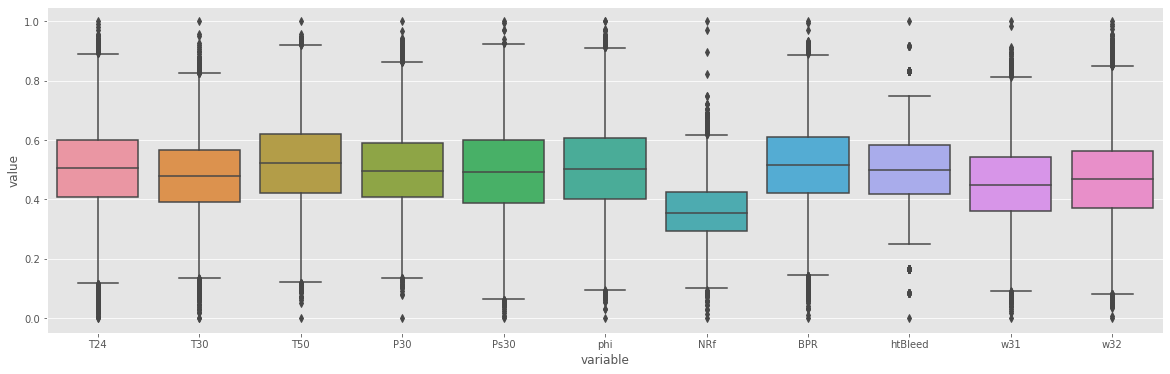

In [ ]:
train1_minmax = pd.DataFrame(X_train_scaled, columns = sensors)
plt.figure(figsize=(20, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(train1_minmax))
plt.show()

## **Train Classification Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, r2_score, precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

### **MinMax Classification Tree**

In [ ]:
DTCmin = DecisionTreeClassifier(random_state=42)

DTCmin.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
yhat_train = DTCmin.predict(X_train_scaled)
evaluate(y_train, yhat_train, 'train')

train set RMSE:0.0, R2:1.0


In [ ]:
yhat_val = DTCmin.predict(X_val_scaled)
evaluate(y_val, yhat_val, 'val')

val set RMSE:0.759005057790385, R2:0.7131453300096446


In [ ]:
yhat_test = DTCmin.predict(X_test_scaled)
evaluate(y_test, yhat_test, 'test')

test set RMSE:0.8900282438738094, R2:-0.2872539587057228


#### **MinMax Evaluation**

In [ ]:
pip install -U yellowbrick

     |████████████████████████████████| 276kB 4.2MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [ ]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

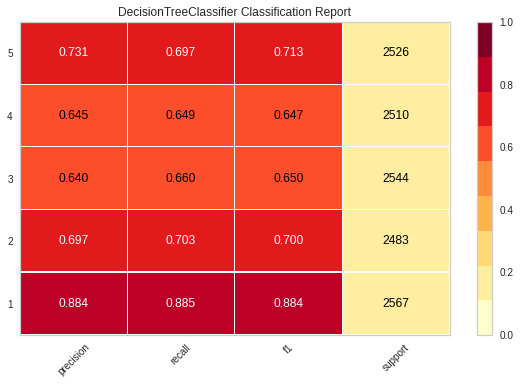

In [ ]:
viz = ClassificationReport((DTCmin), per_class=True, support=True)
viz.fit(X_train_scaled, y_train)
viz.score(X_val_scaled, y_val)
viz.show()

**Test Set**

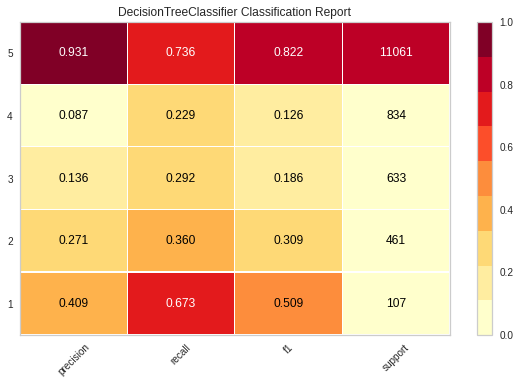

In [ ]:
viz = ClassificationReport((DTCmin), per_class=True, support=True)
viz.fit(X_train_scaled, y_train)
viz.score(X_test_scaled, y_test)
viz.show()

### **Validation Confusion Matrix**

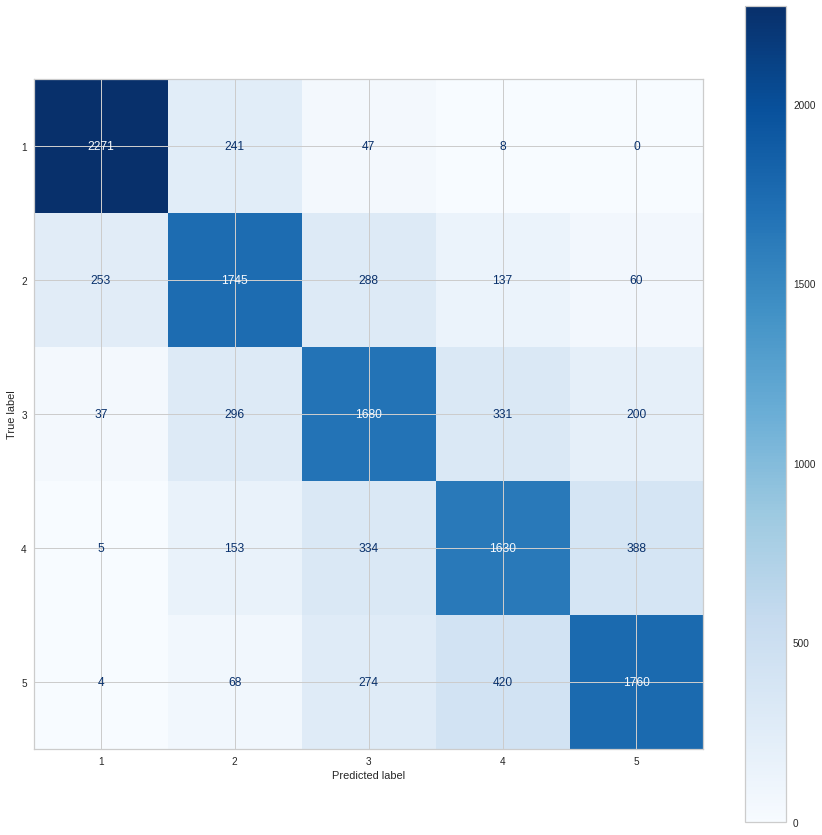

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(DTCmin, X_val_scaled, y_val, cmap=plt.cm.Blues, ax=ax)

In [ ]:
precision, recall, fscore, support = score(y_val, yhat_val)

print('precision on val: {}'.format(precision))
print('recall on val: {}'.format(recall))
print('fscore on val: {}'.format(fscore))
print('support on test: {}'.format(support))

precision on val: [0.88365759 0.6971634  0.64048799 0.64528899 0.73089701]
recall on val: [0.8846903  0.7027789  0.66037736 0.64940239 0.69675376]
fscore on val: [0.88417364 0.69995989 0.65028063 0.64733916 0.71341711]
support on test: [2567 2483 2544 2510 2526]


### **Test Confusion Matrix**

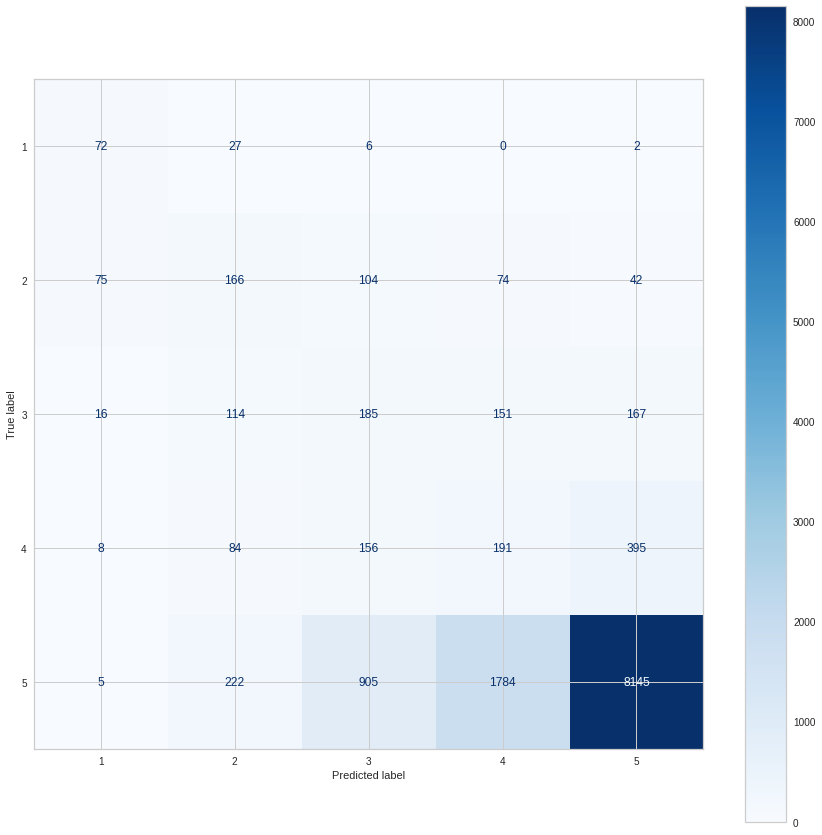

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(DTCmin, X_test_scaled, y_test, cmap=plt.cm.Blues, ax=ax)

In [ ]:
precision, recall, fscore, support = score(y_test, yhat_test)

print('precision on test: {}'.format(precision))
print('recall on test: {}'.format(recall))
print('fscore on test: {}'.format(fscore))
print('support on test: {}'.format(support))

precision on test: [0.40909091 0.27079935 0.13643068 0.08681818 0.93075077]
recall on test: [0.6728972  0.36008677 0.29225908 0.22901679 0.73637103]
fscore on test: [0.50883392 0.30912477 0.18602313 0.12590639 0.82222895]
support on test: [  107   461   633   834 11061]


The model performed much worse on the test set compared to the validation set. This is likely due to the imbalanced nature of the test set as well as the overall RUL distribution.

#### **MinMax GridSearch**

Since we are doing a multiclass evaluation, we will have to define our scoring strategy that aligns with our business objective. In our case, we are interested in the recall. We will use the "weighted" average to account for class imbalance which works by computing the average metrics where each class's score is weighted by its presence in the true data sample.  
[Scikit-Learn Reference](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
# Define scoring strategy
weighted_recall = make_scorer(recall_score, average='weighted')

In [ ]:
"""
param_dict = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(1, 10),
    'min_samples_split':range(1,10),
    'min_samples_leaf':range(1,5)
}
"""

"\nparam_dict = {\n    'criterion':['gini', 'entropy'],\n    'max_depth':range(1, 10),\n    'min_samples_split':range(1,10),\n    'min_samples_leaf':range(1,5)\n}\n"

In [ ]:
"""
DTCminGrid = GridSearchCV(DTCmin,
                          param_grid=param_dict,
                          cv=5,
                          scoring=weighted_recall,
                          verbose=1,
                          n_jobs=-1)
DTCminGrid.fit(X_train_scaled, y_train)
"""

'\nDTCminGrid = GridSearchCV(DTCmin,\n                          param_grid=param_dict,\n                          cv=5,\n                          scoring=weighted_recall,\n                          verbose=1,\n                          n_jobs=-1)\nDTCminGrid.fit(X_train_scaled, y_train)\n'

In [ ]:
#DTCminGrid.best_params_

In [ ]:
# Store the best parameters
#DTCbest = DTCminGrid.best_estimator_

In [ ]:
#DTCminGrid.best_score_

In [ ]:
#DTCminScore = DTCminGrid.best_score_

### **Best Tree from GridSearch**  
  
Best Parameters from GridSearch:  
*  Criterion : Gini  
*  max_depth : 9  
*  min_samples_leaf : 1  
*  min_samples_split : 2  
  
We stored our parameters under the DTCbest variable, but we will train our best model below so we don't have to run the GridSearch again.


In [ ]:
DTCbest = DecisionTreeClassifier(criterion='gini', max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=42)

DTCbest.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=9, random_state=42)

In [ ]:
yhat_train = DTCbest.predict(X_train_scaled)
evaluate(y_train, yhat_train, 'train')

train set RMSE:0.8342408023868717, R2:0.6534721849530583


In [ ]:
yhat_val = DTCbest.predict(X_val_scaled)
evaluate(y_val, yhat_val, 'val')

val set RMSE:0.8653165682350445, R2:0.6271598936092921


In [ ]:
yhat_test = DTCbest.predict(X_test_scaled)
evaluate(y_test, yhat_test, 'test')

test set RMSE:0.8272892194736373, R2:-0.11217054481197164


## **Tree Evaluaion Metrics**

### **Cross-Validation with StratifiedKFold**  
  
The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. This isn't really necessary since we dealt with our imbalanced dataset using ADASYN, but it is good practice non the less.  
At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the validation folds. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

#### **Training set Cross-Validation**

In [ ]:
y_train = y_train.to_numpy()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train_scaled, y_train):
    clone_DTCbest = clone(DTCbest)
    X_train_folds = X_train_scaled[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train_scaled[test_index]
    y_test_fold = y_train[test_index]

    clone_DTCbest.fit(X_train_folds, y_train_folds)
    y_pred = clone_DTCbest.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print((n_correct / len(y_pred))*100)

56.91805225653207
56.72572503216866
56.38919132930813
56.141740077204794
56.60694843115907


#### **Validation set Cross-Validation**

In [ ]:
y_val = y_val.to_numpy()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_val_scaled, y_val):
    clone_DTCbest = clone(DTCbest)
    X_val_folds = X_val_scaled[train_index]
    y_val_folds = y_val[train_index]
    X_test_fold = X_val_scaled[test_index]
    y_test_fold = y_val[test_index]

    clone_DTCbest.fit(X_val_folds, y_val_folds)
    y_pred = clone_DTCbest.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print((n_correct / len(y_pred))*100)

52.96912114014252
54.315122723673795
53.00870942201108
54.552652414885195
49.7624703087886


#### **Test set Cross-Validation**

In [ ]:
y_test = y_test.to_numpy()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_test_scaled, y_test):
    clone_DTCbest = clone(DTCbest)
    X_test_folds = X_test_scaled[train_index]
    y_test_folds = y_test[train_index]
    X_test_fold = X_test_scaled[test_index]
    y_test_fold = y_test[test_index]

    clone_DTCbest.fit(X_test_folds, y_test_folds)
    y_pred = clone_DTCbest.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print((n_correct / len(y_pred))*100)

84.19847328244275
83.42878961435662
83.81061473844979
83.50515463917526
84.7269950362734


### **Accuracy Comparison between 10 class tree and 5 class tree with ADASYN**

The 10 class tree from the previous note book had an accuracy of 30%.  
The 5 class tree with ADASYN has an accuracy of 56% for the training set, 
52% for the validation set and 83% for the test set.  
The test set scored significantly higher than both the training and validation sets due to the dataset being imbalanced. The model would just predict Class 5 and still get a high accuracy.


### **Classification Report**
We will be using the Yellowbrick library to evaluate our model

In [ ]:
pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.6/dist-packages (1.3.post1)


In [ ]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

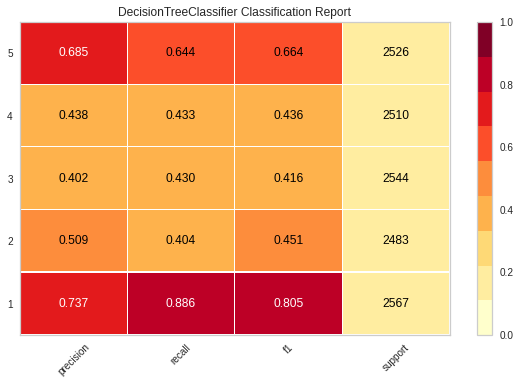

In [ ]:
viz = ClassificationReport((DTCbest), per_class=True, support=True)
viz.fit(X_train_scaled, y_train)
viz.score(X_val_scaled, y_val)
viz.show()

**Test Set**

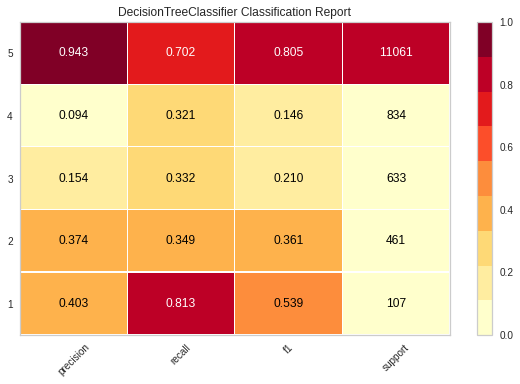

In [ ]:
viz = ClassificationReport((DTCbest), per_class=True, support=True)
viz.fit(X_train_scaled, y_train)
viz.score(X_test_scaled, y_test)
viz.show()

### **ROC-AUC Receiver Operating Characteristic**

In [ ]:
from yellowbrick.classifier import ROCAUC

**Validation Set**

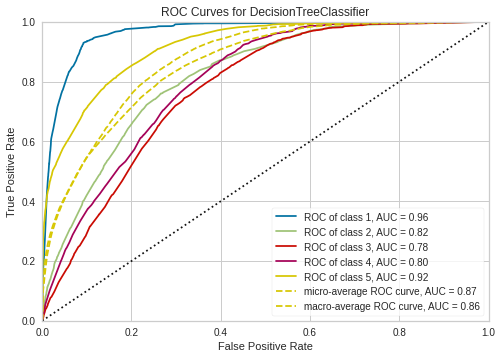

In [ ]:
model = DTCbest
visualizer = ROCAUC(model)
visualizer.fit(X_train_scaled, y_train)       
visualizer.score(X_val_scaled, y_val)        
visualizer.show()                      

**Test Set**

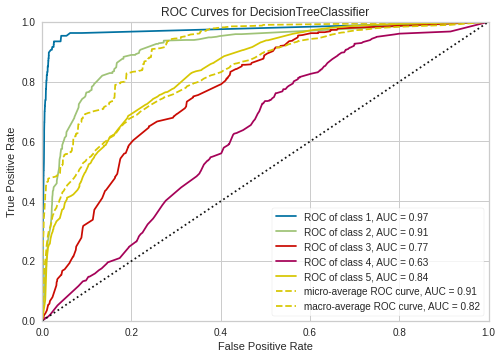

In [ ]:
model = DTCbest
visualizer = ROCAUC(model)
visualizer.fit(X_train_scaled, y_train)       
visualizer.score(X_test_scaled, y_test)       
visualizer.show()               

### **Precision-Recall Curves**

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve

**Validation Set**

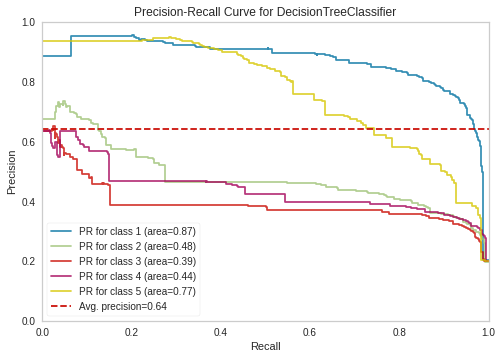

In [ ]:
viz = PrecisionRecallCurve((DTCbest), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train_scaled, y_train)
viz.score(X_val_scaled, y_val)
viz.show()

**Test Set**

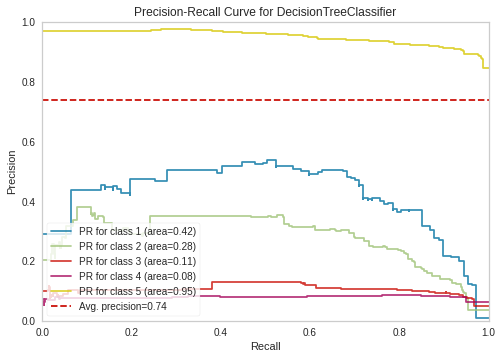

In [ ]:
viz = PrecisionRecallCurve((DTCbest), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train_scaled, y_train)
viz.score(X_test_scaled, y_test)
viz.show()

### **Class Prediction Error**  
This plot shows the support (number of training samples) for each class in the fitted classification model as a stacked bar chart. Each bar is segmented to show the proportion of predictions (including false negatives and false positives, like a Confusion Matrix) for each class. This plot will allow us to visualize which classes the classifier is having difficulty with and what incorrect answers it is giving on a per-class basis. This will enable us to better undertand the strengths and weaknesses of our model. 

In [ ]:
from yellowbrick.classifier import ClassPredictionError

**Validation Set**

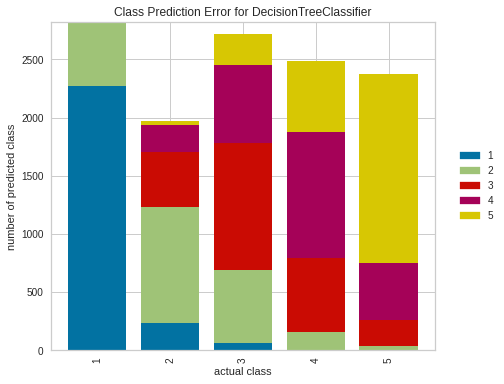

In [ ]:
viz = ClassPredictionError(DTCbest)
viz.fit(X_train_scaled, y_train)
viz.score(X_val_scaled, y_val)
viz.show()

**Test Set**

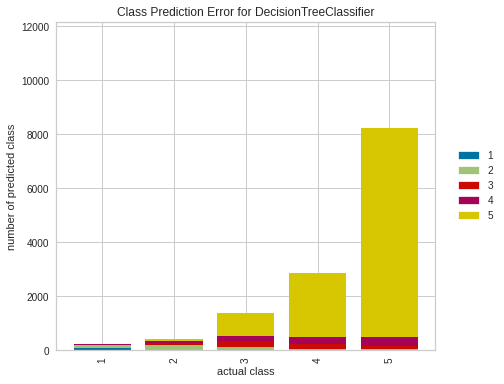

In [ ]:
viz = ClassPredictionError(DTCbest)
viz.fit(X_train_scaled, y_train)
viz.score(X_test_scaled, y_test)
viz.show()

### **Test Confusion Matrix**

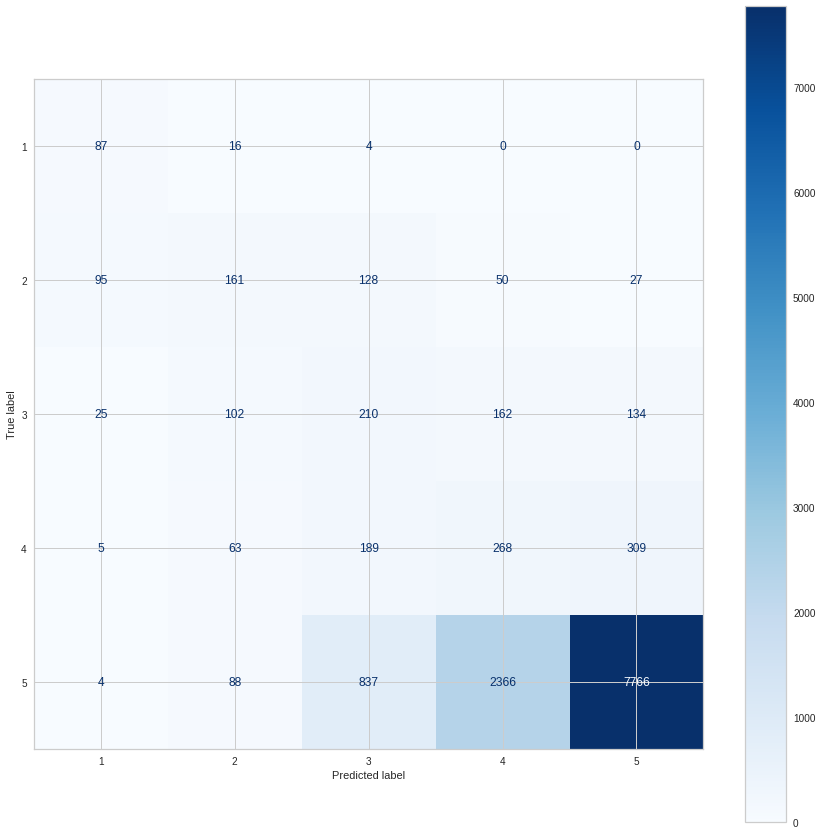

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(DTCbest, X_test_scaled, y_test, cmap=plt.cm.Blues, ax=ax)

## **Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install joblib

In [ ]:
import joblib

In [ ]:
model_save_name = '5_class_tree'
path = F"/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/{model_save_name}"
joblib.dump(DTCbest, path)

['/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/5_class_tree']

In [ ]:
DTCbest = joblib.load('/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/5_class_tree')

In [ ]:
DTCbest

DecisionTreeClassifier(max_depth=9, random_state=42)

## **Dimensionality Reduction**  
  
First, we will create a new dataframe from the original train1_class dataframe. We will take a representative sample for visualization purposes using Scikit_Learn stratified sample split, 10%.

### **Plotting Functions**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import plotly.io as plt_io
import plotly.graph_objects as go
import time

In [ ]:
PCA_df = ADASYN_df

In [ ]:
# Create a 10% representative subsample
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
for train_index, test_index in split.split(PCA_df, PCA_df['RULclass']):
  PCA_train = PCA_df.loc[train_index]
  PCA_val = PCA_df.loc[test_index]

In [ ]:
X_PCA = PCA_val.drop(['RULclass'], axis=1)
y_PCA = PCA_val['RULclass'].copy()

In [ ]:
def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y_PCA, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=1500,height=800)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()

In [ ]:
def plot_3d(component1,component2,component3):

    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=10,
            color=y_PCA,                # set color to an array/list of desired values
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1
        )
    )])
# tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1500,height=800)
    fig.layout.template = 'plotly_dark'
    
    fig.show()

### **PCA (Principal Component Analysis)**  

PCA works by identifying the hyperplane that lies closest to the data and then projects the data on that hyperplane while retaining most of the dataset variation.  
We will do some PCA visualization to see how our RUL classes are clustered.

In [ ]:
start = time.time()
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_PCA)
print('Duration: {} seconds'.format(time.time() - start))
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

#### **2D PCA**

In [ ]:
plot_2d(principalComponents[:, 0],principalComponents[:, 1])

#### **3D PCA**

In [ ]:
plot_3d(principalComponents[:, 0],principalComponents[:, 1],principalComponents[:, 2])

### **t-SNE (T-distributed stochastic neighbor embedding)**  
  
(t-SNE) takes a high dimensional data set and reduces it to a low dimensional graph that retains a lot of the original information. It does so by giving each data point a location in a two or three-dimensional map. This technique finds clusters in data, thereby ensuring that an embedding preserves the meaning in the data. t-SNE reduces dimensionality while keeping similar instances close and dissimilar instances apart.

In [ ]:
start = time.time()
pca_3 = PCA(n_components=3)
pca_result_3 = pca_3.fit_transform(X_PCA)
tsne = TSNE(random_state = 42, n_components=3,verbose=0, perplexity=40, n_iter=400).fit_transform(pca_result_3)
print('Duration: {} seconds'.format(time.time() - start))

#### **2D t-SNE**

In [ ]:
plot_2d(tsne[:, 0],tsne[:, 1])

#### **3D t-SNE**

In [ ]:
plot_3d(tsne[:, 0],tsne[:, 1],tsne[:, 2])

### **LDA (Linear Discriminant Analysis)**  
  
Linear Discriminant Analysis (LDA) is most commonly used as a dimensionality reduction technique in the pre-processing step for pattern-classification.
The goal is to project a dataset onto a lower-dimensional space with good class-separability to avoid overfitting and reduce computational costs.

In [ ]:
start = time.time()
X_LDA = LDA(n_components=3).fit_transform(X_PCA,y_PCA)
print('Duration: {} seconds'.format(time.time() - start))

#### **2D LDA**

In [ ]:
plot_2d(X_LDA[:, 0],X_LDA[:, 1])

#### **3D LDA**

In [ ]:
plot_3d(X_LDA[:, 0],X_LDA[:, 1],X_LDA[:, 2])

### **UMAP (Uniform Manifold Approximation and Projection)**  
  
UMAP is a nonlinear dimensionality reduction method; it helps visualize clusters or groups of data points and their relative proximities.
UMAP is similar to t-SNE but with probably higher processing speed, therefore, faster and better visualization.

In [ ]:
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(X_PCA)
print('Duration: {} seconds'.format(time.time() - start))

#### **2D UMAP**

In [ ]:
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1])

#### **3D UMAP**

In [ ]:
plot_3d(reducer.embedding_[:, 0],reducer.embedding_[:, 1],reducer.embedding_[:, 2])

## **Discussion**  
Looking at the classification report, we can see from the support that we have a reasonably balanced dataset, thanks to the ADASYN that we implemented earlier. We will focus on the Class 1 results, as those are most directly related to our business problem. The precision, recall, and F1 scores are all reasonable for our classification model's first attempt. But, when we look at the test set results, things start to fall apart.  
It is interesting to note that the recall is still over 80%, which is more important to us. The consequences of overestimating the RUL are far less than overestimating the RUL.   
Looking at the ROC curves, the test set performs better than the validation set. The results are only slightly better on the test set, so this could be attributed to random variation as the calculated AUC value is a function of the present sample. The next steps would include multiple train/test splits to quantify the variability of the AUC by cross-validation.  
The precision-recall curves show a more telling story. The test set performs significantly worse than the validation set, which can be attributed to the test set's highly imbalanced data.  
Future work will include applying an asymmetric loss function to the various ML algorithms to penalize late RUL predictions. We could also use different Sckikit-Learn parameters to deal with the imbalanced data, such as class weights.  
Looking at the class prediction error plot for the validation set, we can see our model performs reasonably well. Ideally, we would not see any class 1 (blue) in the later classes, something that the class weights and loss functions will address. Our model performs best on classes 1 and 5, the extremities, which makes sense given the nature of our sensors' data distribution.  
**Dimensionality Reduction**  
For the dimensionality reduction, we took a representative sample, 10% based on class distribution, for visualization purposes.
When comparing the PCA between the 10 and 5 class trees, the 10 class PCA shows a better cluster separation for class 1. When we look at the 3D plot of the 5 class PCA, some planes run along the y-axis at a 45-degree angle. These planes don't appear to reflect the data; they are likely from the sub-sampling we did. Overall, PCA did not create well-defined clusters for our classes.   
t-SNE (T-distributed stochastic neighbour embedding) finds clusters in data to reduce dimensionality while keeping similar instances close and dissimilar instances apart. As with PCA, t-SNE failed to generate any well-defined clusters for our classes. In our example, the 5 class t-SNE plot appeared to have a more uniform distribution than the 10 class plot. The 10 class plots had more of a wave function shape, whereas the 5 class plots were more of a flattened bowl.    
LDA (Linear Discriminant Analysis) is similar to PCA, except that rather than finding the component axes that maximize the variance of our data, we are also interested in the axes that maximize the separation between our classes.  There becomes evident when we look at our plot. The 10 and 5 class plots show better class separation than the previous reduction techniques, especially the 5 class plots. The PCA plots showed some separation on the extremities, but the rest of the classes were all mixed, something that our class prediction error plot also showed. Again, this makes sense when we look at our sensor data and see the decay rate increases as the RUL decreases. Our model has a tough time distinguishing classes between the extremities because the data does not have a lot of variation. The values between class 1 and class 5, for example, are easy to distinguish between. Still, the values between classes 2-4 are more similar, and it becomes difficult to find a clear definition or separation between the class boundaries.    
UMAP (Uniform Manifold Approximation and Projection) is a nonlinear dimensionality reduction technique that effectively visualizes clusters and their relative proximities. UMAP is similar to t-SNE but with higher processing speeds. When we look at the 10 and 5 class plots for UMAP we see a similar outcome to the t-SNE: nonlinear shapes with minimal class separation. Again, the extremity classes are better defined than those in between.  
For our dataset, LDA performed the best, and we will use it going forward as we adjust our model parameters and assumptions.

## **Class Weights**

In [ ]:
X_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_train_scaled.csv')
y_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_train.csv')

X_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_val_scaled.csv')
y_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_val.csv')

X_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_test_scaled.csv')
y_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_test.csv')

In [ ]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

### **Class Distribution**

In [ ]:
fig = px.histogram(y_train, x='RULclass')
fig.show()

In [ ]:
fig = px.histogram(y_val, x='RULclass')
fig.show()

In [ ]:
fig = px.histogram(y_test, x='RULclass')
fig.show()

### **Balanced Tree**  
To tackle the imbalanced dataset we are first going to try Scikit-Learn's *class_weight:"balanced"* parameter. The "balanced" mode uses the values of y to automatically adjust weights so they are inversely proportional to the class frequencies in the input data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
DTCbalanced = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=42)
DTCbalanced.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=9, random_state=42)

#### **Balanced Tree Evaluation**

##### **Classification Report**

In [ ]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

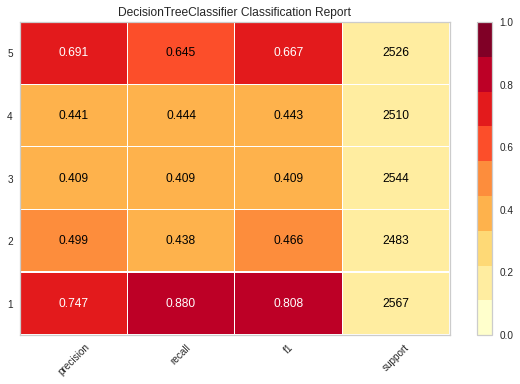

In [ ]:
viz = ClassificationReport((DTCbalanced), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

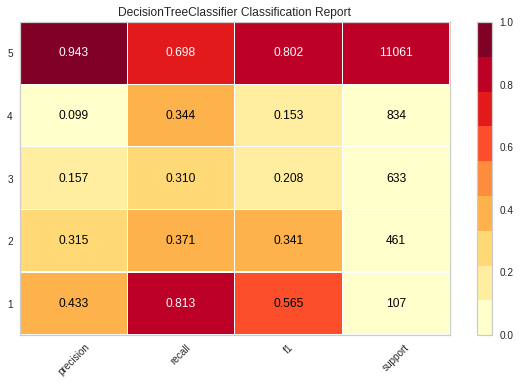

In [ ]:
viz = ClassificationReport((DTCbalanced), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **ROC-AUC Receiver Operating Characteristic**

In [ ]:
from yellowbrick.classifier import ROCAUC

**Validation Set**

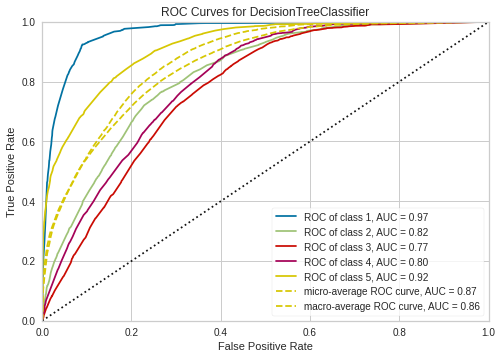

In [ ]:
model = DTCbalanced
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_val, y_val)
visualizer.show()

**Test Set**

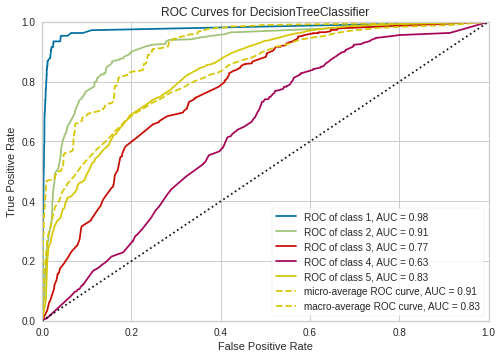

In [ ]:
model = DTCbalanced
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_test, y_test)
visualizer.show()

##### **Precision-Recall Curves**

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve

**Validation Set**

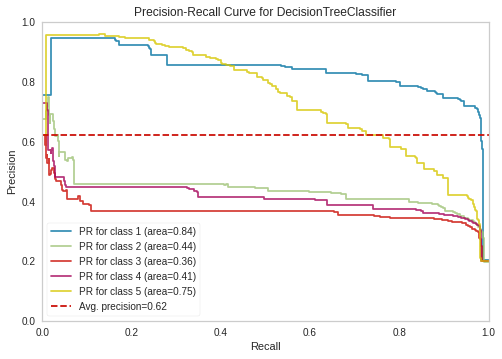

In [ ]:
viz = PrecisionRecallCurve((DTCbalanced), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

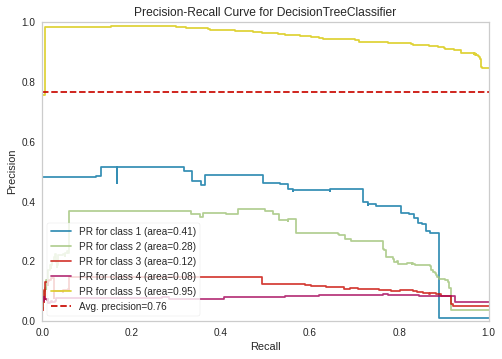

In [ ]:
viz = PrecisionRecallCurve((DTCbalanced), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Class Prediction Error**  

In [ ]:
from yellowbrick.classifier import ClassPredictionError

**Validation Set**  
Had to convert y_val to 1D array

In [ ]:
y_val = y_val.to_numpy()

In [ ]:
y_val = y_val.flatten()

In [ ]:
y_val.ndim

1

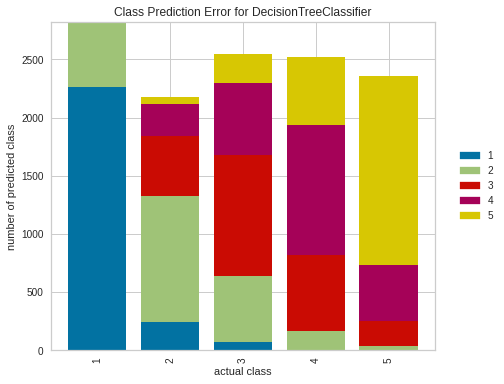

In [ ]:
viz = ClassPredictionError((DTCbalanced), per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

In [ ]:
y_test = y_test.to_numpy()

In [ ]:
y_test = y_test.flatten()

In [ ]:
y_test.ndim

1

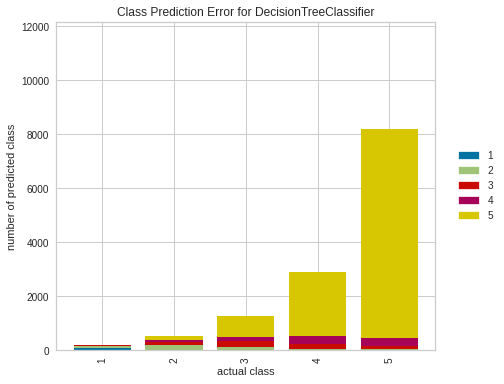

In [ ]:
viz = ClassPredictionError(DTCbalanced)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Confusion Matrix**  

**Validation Set**

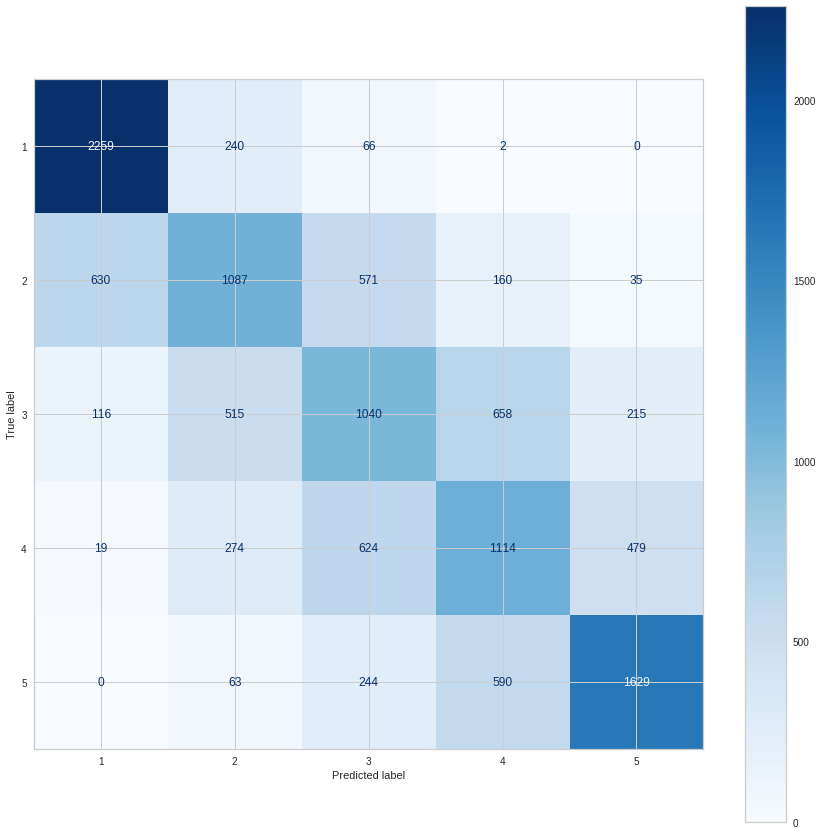

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(DTCbalanced, X_val, y_val, cmap=plt.cm.Blues, ax=ax)

**Test Set**

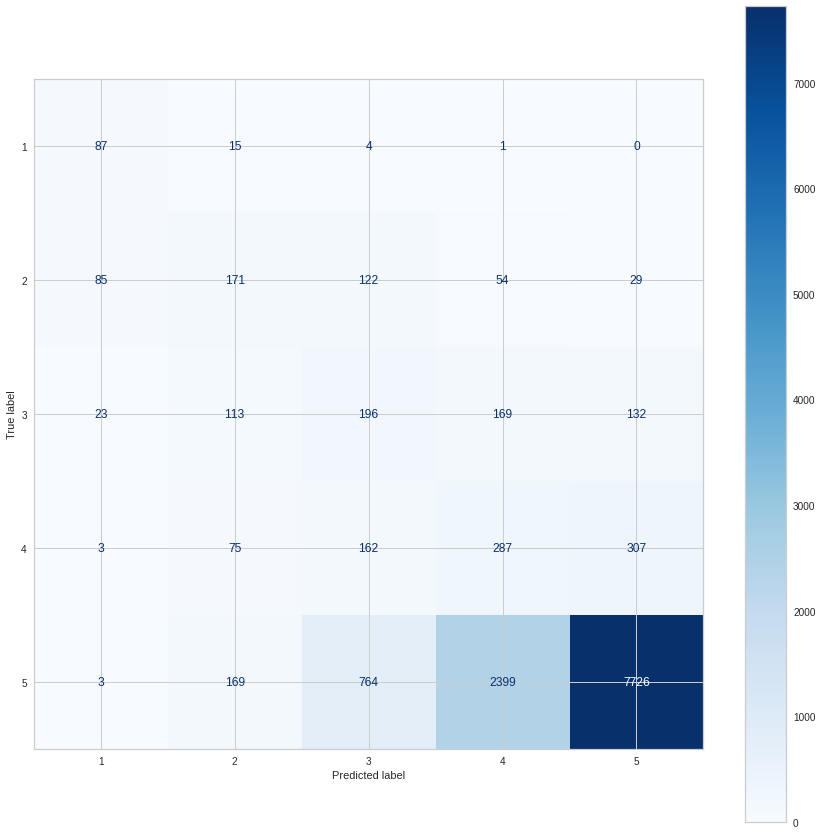

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(DTCbalanced, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

## **Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import joblib

In [ ]:
model_save_name = '5_class_tree_balanced'
path = F"/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/{model_save_name}"
joblib.dump(DTCbalanced, path)

['/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/5_class_tree_balanced']

In [ ]:
DTCbalanced = joblib.load('/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/5_class_tree_balanced')

In [ ]:
DTCbalanced

DecisionTreeClassifier(class_weight='balanced', max_depth=9, random_state=42)

### **Results**  
By changing the class weights to represent the class imbalance, we increased the ROC-AUC by 1%, increasing the average precision by 2% with a decrease in PR for class 1 of 1%.  Our F1 score also improved by 2.6%. This isn't much of an improvement, but it gave us some insights to apply going forward.